In [1]:
# 查看当前挂载的数据集目录
!ls /home/aistudio/data/

data65


In [2]:
# 查看个人持久化工作区文件
!ls /home/aistudio/work/

In [3]:
%matplotlib inline
import numpy as np
import paddle
import paddle.fluid as fluid
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os


z_dim = 100
batch_size = 128
step_per_epoch = 60000 / batch_size

In [4]:
def generator(z, name="G"):
#     with fluid.unique_name.guard(name+'_'):
#         fc1 = fluid.layers.fc(input = z, size = 1024)
#         fc1 = fluid.layers.fc(fc1, size = 128 * 7 * 7)
#         fc1 = fluid.layers.batch_norm(fc1,act = 'relu')
#         fc1 = fluid.layers.reshape(fc1, shape=(-1, 128, 7, 7))

    
#         conv1 = fluid.layers.conv2d(fc1, num_filters = 4*64,
#                                     filter_size=5, stride=1, 
#                                     padding=2, act='relu')
#         conv1 = fluid.layers.reshape(conv1, shape=(-1,64,14,14))
        
#         conv2 = fluid.layers.conv2d(conv1, num_filters = 4*32, 
#                                     filter_size=5, stride=1,
#                                     padding=2, act='relu')
#         conv2 = fluid.layers.reshape(conv2, shape=(-1,32,28,28))
        
#         conv3 = fluid.layers.conv2d(conv2, num_filters = 1, 
#                                     filter_size=5, stride=1,
#                                     padding=2,act='relu')
# #         conv3 = fluid.layers.reshape(conv3, shape=(-1,1,28,28))
#         print("conv3",conv3)
#         return conv3
    with fluid.unique_name.guard(name + "/"):
        y = z
        
        y = fluid.layers.fc(y, size=1024, act='tanh')
        y = fluid.layers.fc(y, size=128 * 7 * 7)
        y = fluid.layers.batch_norm(y, act='tanh')
        y = fluid.layers.reshape(y, shape=(-1, 128, 7, 7))

        y = fluid.layers.image_resize(y, scale=2)
        y = fluid.layers.conv2d(y, num_filters=64, filter_size=5, padding=2, act='tanh')

        y = fluid.layers.image_resize(y, scale=2)
        y = fluid.layers.conv2d(y, num_filters=1, filter_size=5, padding=2, act='tanh')

    return y
        

In [5]:
def discriminator(image, name="D"):
#     with fluid.unique_name.guard(name+'_'):
#         conv1 = fluid.layers.conv2d(input=image, num_filters=32,
#                                     filter_size=6, stride=2,
#                                     padding=2)
#         conv1_act = fluid.layers.leaky_relu(conv1)
        
#         conv2 = fluid.layers.conv2d(conv1_act, num_filters=64, 
#                                     filter_size=6, stride=2,
#                                     padding=2)
#         conv2 = fluid.layers.batch_norm(conv2)
#         conv2_act = fluid.layers.leaky_relu(conv2)
        
#         fc1 = fluid.layers.reshape(conv2_act, shape=(-1,64*7*7))
#         fc1 = fluid.layers.fc(fc1, size=512)
#         fc1_bn = fluid.layers.batch_norm(fc1)
#         fc1_act = fluid.layers.leaky_relu(fc1_bn)
        
#         #有没有sigmoid的act???
#         fc2 = fluid.layers.fc(fc1_act, size=1, act='sigmoid')
#         print("fc2",fc2)
#         return fc2
    def conv_bn(input, num_filters, filter_size):
        y = fluid.layers.conv2d(
            input,
            num_filters=num_filters, 
            filter_size=filter_size,
            padding=0,
            stride=1,
            bias_attr=False)
        y = fluid.layers.batch_norm(y)
        y = fluid.layers.leaky_relu(y)
        return y

    with fluid.unique_name.guard(name + "/"):
        y = image
        
        y = conv_bn(y, num_filters=32, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)
        
        y = conv_bn(y, num_filters=64, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)
        
        y = conv_bn(y, num_filters=128, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)
        
        y = fluid.layers.fc(y, size=1)

    return y

In [6]:
def get_params(program, prefix):
    all_params = program.global_block().all_parameters()
    return [t.name for t in all_params if t.name.startswith(prefix)]

In [7]:
#优化generator
G_program = fluid.Program()
with fluid.program_guard(G_program):
    z = fluid.layers.data(name='z', shape=[z_dim,1,1])
    # 用生成器G生成样本图片
    G_sample = generator(z)
    infer_program = G_program.clone(for_test=True)
    # 用判别器D判别生成的样本
    D_fake = discriminator(G_sample)
    
#     ones = fluid.layers.fill_constant_batch_size_like(z, shape=[-1, 1], dtype='float32', value=1)
    # G损失
    # G Least square cost
    G_loss = fluid.layers.reduce_mean(fluid.layers.square(D_fake-1))/2.
    # 获取G的参数
    G_params = get_params(G_program, "G")
    
    # 使用Adam优化器
    G_optimizer = fluid.optimizer.Adam(learning_rate=0.0002)
    # 训练G
    G_optimizer.minimize(G_loss,parameter_list = G_params)
    print(G_params)

['G/G/fc_0.w_0', 'G/G/fc_0.b_0', 'G/G/fc_1.w_0', 'G/G/fc_1.b_0', 'G/G/batch_norm_0.w_0', 'G/G/batch_norm_0.b_0', 'G/G/batch_norm_0.w_1', 'G/G/batch_norm_0.w_2', 'G/G/conv2d_0.w_0', 'G/G/conv2d_0.b_0', 'G/G/conv2d_1.w_0', 'G/G/conv2d_1.b_0']


In [8]:
# 优化discriminator
D_program = fluid.Program()
with fluid.program_guard(D_program):
    z = fluid.layers.data(name='z', shape=[z_dim,1,1])
    # 用生成器G生成样本图片
    G_sample = generator(z)
    real = fluid.layers.data(name='img', shape=[1, 28, 28])
    # 用判别器D判别真实的样本
    D_real = discriminator(real)
    # 用判别器D判别生成的样本
    D_fake = discriminator(G_sample)
    # D损失
    print("D_real",D_real)
    print("D_fake",D_fake)
    # D Least square cost
    D_loss = fluid.layers.reduce_mean(fluid.layers.square(D_real-1.)+fluid.layers.square(D_fake))/2.
    print("D_loss",D_loss)
    # 获取D的参数列表
    D_params = get_params(D_program, "D")
    # 使用Adam优化
    D_optimizer = fluid.optimizer.Adam(learning_rate=0.0002)
    D_optimizer.minimize(D_loss, parameter_list = D_params)
    print(D_params)

('D_real', name: "D/D/fc_0.tmp_1"
type {
  type: LOD_TENSOR
  lod_tensor {
    tensor {
      data_type: FP32
      dims: -1
      dims: 1
    }
    lod_level: 0
  }
}
persistable: false
)
('D_fake', name: "D/D/fc_0.tmp_1"
type {
  type: LOD_TENSOR
  lod_tensor {
    tensor {
      data_type: FP32
      dims: -1
      dims: 1
    }
    lod_level: 0
  }
}
persistable: false
)
('D_loss', name: "tmp_8"
type {
  type: LOD_TENSOR
  lod_tensor {
    tensor {
      data_type: FP32
      dims: 1
    }
    lod_level: 0
  }
}
)
['D/D/conv2d_0.w_0', 'D/D/batch_norm_0.w_0', 'D/D/batch_norm_0.b_0', 'D/D/batch_norm_0.w_1', 'D/D/batch_norm_0.w_2', 'D/D/conv2d_1.w_0', 'D/D/batch_norm_1.w_0', 'D/D/batch_norm_1.b_0', 'D/D/batch_norm_1.w_1', 'D/D/batch_norm_1.w_2', 'D/D/conv2d_2.w_0', 'D/D/batch_norm_2.w_0', 'D/D/batch_norm_2.b_0', 'D/D/batch_norm_2.w_1', 'D/D/batch_norm_2.w_2', 'D/D/fc_0.w_0', 'D/D/fc_0.b_0']


In [9]:
def show_image_grid(images, epoch=None): # images.shape = (64, 1, 28, 28)
    fig = plt.figure(figsize=(5, 5))
    fig.suptitle("Epoch {}".format(epoch))
    gs = plt.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, image in enumerate(images[:64]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
#         plt.imshow(image[0], cmap='Greys_r')
        plt.imshow(image[0], cmap='Greys_r')
    plt.show()

In [10]:
batch_size = 128
step_per_epoch = 60000 / batch_size

# 噪声生成
def z_reader():
    while True:
        yield np.random.normal(0.0, 1.0, (z_dim, 1, 1)).astype('float32')

In [11]:
# MNIST数据集，不使用label
def mnist_reader(reader):
    def r():
        for img, label in reader():
            yield img.reshape(1, 28, 28)
    return r

mnist_generator = paddle.batch(
    paddle.reader.shuffle(mnist_reader(paddle.dataset.mnist.train()), 1024), batch_size=batch_size)
z_generator = paddle.batch(z_reader, batch_size=batch_size)()

In [12]:
place = fluid.CUDAPlace(0) if fluid.core.is_compiled_with_cuda() else fluid.CPUPlace()
exe = fluid.Executor(place)
exe.run(program=fluid.default_startup_program())

[]

In [13]:
np.random.seed(0)
test_z = np.array(next(z_generator))
#print("test_z",test_z) 

Epoch 0 batch 0 d 2.8164973259 g 1.43883121014
Epoch 0 batch 50 d 0.636442005634 g 0.325216114521
Epoch 0 batch 100 d 0.517108976841 g 0.260657995939
Epoch 0 batch 150 d 0.471043527126 g 0.236626803875
Epoch 0 batch 200 d 0.451658725739 g 0.22680722177
Epoch 0 batch 250 d 0.435774385929 g 0.219528660178
Epoch 0 batch 300 d 0.421981304884 g 0.2120334059
Epoch 0 batch 350 d 0.410467773676 g 0.20546759665
Epoch 0 batch 400 d 0.400887578726 g 0.200612202287
Epoch 0 batch 450 d 0.392869889736 g 0.196935191751


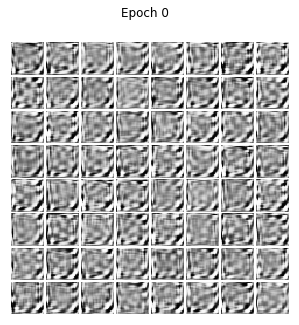

Epoch 1 batch 0 d 0.314987063408 g 0.171923607588
Epoch 1 batch 50 d 0.31362298131 g 0.158714652061
Epoch 1 batch 100 d 0.310502916574 g 0.158309921622
Epoch 1 batch 150 d 0.306904703379 g 0.155289798975
Epoch 1 batch 200 d 0.304867714643 g 0.15249735117
Epoch 1 batch 250 d 0.304448246956 g 0.152763903141
Epoch 1 batch 300 d 0.304363161325 g 0.153938814998
Epoch 1 batch 350 d 0.304408103228 g 0.154508844018
Epoch 1 batch 400 d 0.304631531239 g 0.154250949621
Epoch 1 batch 450 d 0.305488616228 g 0.15534260869


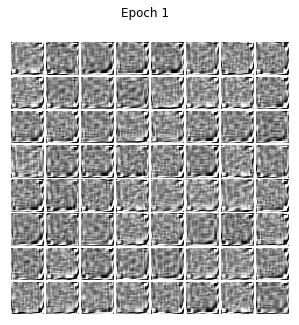

Epoch 2 batch 0 d 0.306572020054 g 0.128494754434
Epoch 2 batch 50 d 0.306120693684 g 0.148605704308
Epoch 2 batch 100 d 0.306505352259 g 0.155622422695
Epoch 2 batch 150 d 0.305653452873 g 0.157948940992
Epoch 2 batch 200 d 0.302171975374 g 0.156000643969
Epoch 2 batch 250 d 0.301745176315 g 0.15592674911
Epoch 2 batch 300 d 0.300289601088 g 0.155284777284
Epoch 2 batch 350 d 0.299079954624 g 0.154955506325
Epoch 2 batch 400 d 0.297915101051 g 0.153827473521
Epoch 2 batch 450 d 0.297568559647 g 0.152607753873


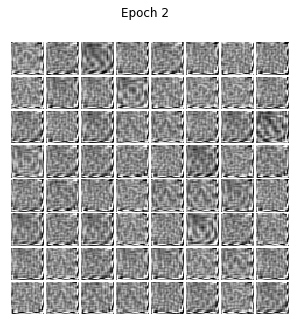

Epoch 3 batch 0 d 0.287593841553 g 0.160310357809
Epoch 3 batch 50 d 0.287496238947 g 0.144660189748
Epoch 3 batch 100 d 0.285048544407 g 0.143893182278
Epoch 3 batch 150 d 0.283238381147 g 0.142946913838
Epoch 3 batch 200 d 0.282791793346 g 0.142699405551
Epoch 3 batch 250 d 0.282987326384 g 0.144223511219
Epoch 3 batch 300 d 0.28521797061 g 0.14638453722
Epoch 3 batch 350 d 0.288687884808 g 0.145187571645
Epoch 3 batch 400 d 0.287000477314 g 0.144569814205
Epoch 3 batch 450 d 0.286319464445 g 0.143880099058


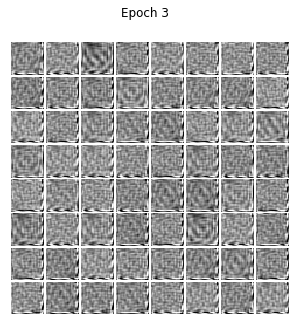

Epoch 4 batch 0 d 0.272333741188 g 0.092084415257
Epoch 4 batch 50 d 0.277509123087 g 0.13523055613
Epoch 4 batch 100 d 0.274942934513 g 0.136852219701
Epoch 4 batch 150 d 0.274478763342 g 0.136987447739
Epoch 4 batch 200 d 0.274158239365 g 0.13827586174
Epoch 4 batch 250 d 0.274329304695 g 0.13853174448
Epoch 4 batch 300 d 0.273940265179 g 0.137371614575
Epoch 4 batch 350 d 0.274486660957 g 0.13740901649
Epoch 4 batch 400 d 0.274709522724 g 0.137919738889
Epoch 4 batch 450 d 0.27391859889 g 0.137756094337


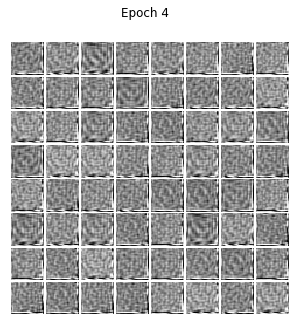

Epoch 5 batch 0 d 0.312295824289 g 0.254007577896
Epoch 5 batch 50 d 0.270959824324 g 0.13333080709
Epoch 5 batch 100 d 0.268633902073 g 0.130956918001
Epoch 5 batch 150 d 0.268249303102 g 0.131332576275
Epoch 5 batch 200 d 0.268447697163 g 0.132498979568
Epoch 5 batch 250 d 0.280625730753 g 0.138473108411
Epoch 5 batch 300 d 0.279086500406 g 0.138299062848
Epoch 5 batch 350 d 0.277455419302 g 0.138627931476
Epoch 5 batch 400 d 0.276032358408 g 0.137879148126
Epoch 5 batch 450 d 0.274680018425 g 0.138169437647


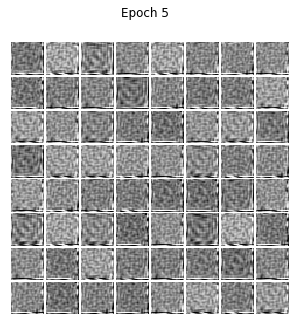

Epoch 6 batch 0 d 0.273949742317 g 0.119704201818
Epoch 6 batch 50 d 0.267923116684 g 0.132283210754
Epoch 6 batch 100 d 0.268152624369 g 0.137397155166
Epoch 6 batch 150 d 0.268728792667 g 0.138070330024
Epoch 6 batch 200 d 0.268175035715 g 0.136601552367
Epoch 6 batch 250 d 0.268643379211 g 0.136819854379
Epoch 6 batch 300 d 0.268660455942 g 0.136809512973
Epoch 6 batch 350 d 0.269147753716 g 0.13713042438
Epoch 6 batch 400 d 0.269098818302 g 0.137293770909
Epoch 6 batch 450 d 0.268762737513 g 0.137411519885


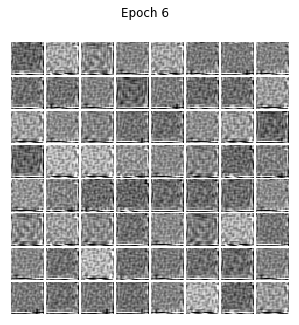

Epoch 7 batch 0 d 0.261931419373 g 0.143097937107
Epoch 7 batch 50 d 0.265166342258 g 0.132438063622
Epoch 7 batch 100 d 0.265695691109 g 0.133834958076
Epoch 7 batch 150 d 0.266818672419 g 0.133847653866
Epoch 7 batch 200 d 0.266024470329 g 0.134690672159
Epoch 7 batch 250 d 0.265906095505 g 0.135141953826
Epoch 7 batch 300 d 0.265479117632 g 0.135266408324
Epoch 7 batch 350 d 0.265803486109 g 0.135092869401
Epoch 7 batch 400 d 0.265623241663 g 0.134554669261
Epoch 7 batch 450 d 0.266705870628 g 0.135080441833


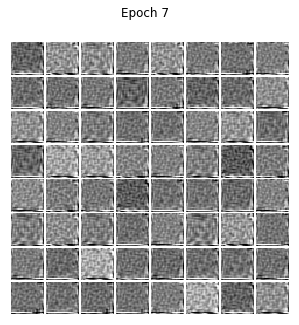

Epoch 8 batch 0 d 0.266326546669 g 0.120966643095
Epoch 8 batch 50 d 0.26240414381 g 0.128241956234
Epoch 8 batch 100 d 0.262854993343 g 0.130651459098
Epoch 8 batch 150 d 0.264559745789 g 0.129707664251
Epoch 8 batch 200 d 0.264684528112 g 0.130285724998
Epoch 8 batch 250 d 0.263923555613 g 0.130456447601
Epoch 8 batch 300 d 0.263667196035 g 0.130671545863
Epoch 8 batch 350 d 0.263489216566 g 0.132378041744
Epoch 8 batch 400 d 0.264000564814 g 0.133167356253
Epoch 8 batch 450 d 0.263772338629 g 0.132926553488


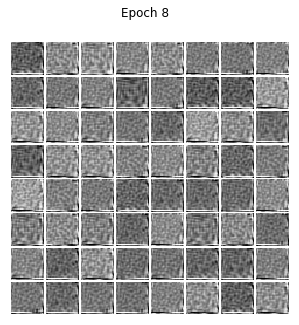

Epoch 9 batch 0 d 0.259923815727 g 0.120865479112
Epoch 9 batch 50 d 0.263578087091 g 0.133192956448
Epoch 9 batch 100 d 0.264746367931 g 0.132435783744
Epoch 9 batch 150 d 0.263925164938 g 0.133797198534
Epoch 9 batch 200 d 0.265070408583 g 0.134544491768
Epoch 9 batch 250 d 0.26542660594 g 0.134832710028
Epoch 9 batch 300 d 0.264450728893 g 0.134704038501
Epoch 9 batch 350 d 0.264357596636 g 0.134230479598
Epoch 9 batch 400 d 0.264235883951 g 0.13486237824
Epoch 9 batch 450 d 0.264642000198 g 0.134967088699


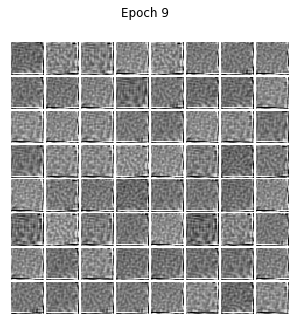

In [14]:
for epoch in range(10):
    epoch_d_loss = []
    epoch_g_loss = []
    
    for i, real_image in enumerate(mnist_generator()):
        step = epoch * step_per_epoch + i
        
        # 训练D识别真实图片 
        r_d = exe.run(D_program, fetch_list=[D_loss], feed={
            'img': np.array(real_image),
            'z': np.array(next(z_generator))
        })
        epoch_d_loss.append(np.mean(r_d))
        
        ## 训练G生成符合D标准的“真实”图片
        r_g = exe.run(G_program, fetch_list=[G_loss], feed={
            'z': np.array(next(z_generator))
        })
        epoch_g_loss.append(np.mean(r_g))
        
        if i % 50 == 0:
            print("Epoch {} batch {} d {} g {}".format(
                epoch, i, np.mean(epoch_d_loss), np.mean(epoch_g_loss)
            ))
        
    # 测试
    r_i = exe.run(infer_program, fetch_list=[G_sample], feed={
        'z': test_z
    })
    show_image_grid(r_i[0], epoch)